![Spark Logo](http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png) + ![Python Logo](http://spark-mooc.github.io/web-assets/images/python-logo-master-v3-TM-flattened_small.png)

Para el procesamiento y operaciones de Big Data, la primer tarea es la recuperación de la información, entendida como la forma en que la información deseada por el usuario es especificada y recuperada del sistema del almacenamiento.

Esta operación se realiza a través de consultas, las cuales utilizan un lenguaje (*Query Language*) que permite especificar la información deseada; estos lenguajes son **declarativos**, es decir, el usuario indica qué necesita en vez de como obtenerlo. No es necesario escribir un programa que indique que archivo se va a abrir, qué bytes tener en cuenta, cuáles no, el tipo de codificación, entre otras.

Iniciaremos revisando la recuperación de datos relacionales, donde el lenguaje más utilizado es *Structured Query Language* o SQL con el cual se definen consultas de la forma:
```sql
SELECT  atributos
FROM    tablas
WHERE   condiciones
```
Donde los atributos son los nombres de las columnas de la tabla.

En relación a lo visto en los modelos de datos, y las operaciones con conjuntos de datos, podríamos ver este tipo de consultas como una selección de los elementos de la tabla que cumplen cierta condición, y la posterior proyección de los atributos deseados.

En este notebook veremos las dos formas que plantea el framework de Apache Spark para la recuperación de información para datos relacionales: los DataFrames y SparkSQL.

# Relational data wrangling with Apache Spark

<small>Adapted from [GitHub](https://github.com/weberdavid/pyspark_course/)</small>

## Google Colaboratory environment set up

In [1]:
# Download Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# Next, we will install Apache Spark 3.0.1 with Hadoop 2.7 from here.
!wget https://dlcdn.apache.org/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
# Now, we just need to unzip that folder.
!tar xf spark-3.5.1-bin-hadoop3.tgz

# Setting JVM and Spark path variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

# Installing required packages
!pip install pyspark==3.5.1
!pip install findspark

--2024-07-31 18:19:11--  https://dlcdn.apache.org/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400446614 (382M) [application/x-gzip]
Saving to: ‘spark-3.5.1-bin-hadoop3.tgz’

spark-3.5.1-bin-had 100%[===================>] 381.90M   218MB/s    in 1.8s    

2024-07-31 18:19:13 (218 MB/s) - ‘spark-3.5.1-bin-hadoop3.tgz’ saved [400446614/400446614]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 980.0 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488490 sha256=ca6b229e49a167a772311c190ed2c85ff9f18a84065cc98abb2015e827a5e58e
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

import findspark
findspark.init()

from pyspark.sql import Window
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as fct

## Using Spark DataFrames

### Create Spark session and import the data

In [3]:
ss = (SparkSession
      .builder
      .appName("wrangling_with_data")
      .getOrCreate())

path = "/content/sparkify-log.json"
user_data = ss.read.json(path)

### Data Exploration

In [4]:
# Información general
user_data.printSchema()
(user_data
 .describe() # describe = variable + tipo de dato; toma variable como parámetro
 .show()) # show = count, mean, stddev, min, max para cada variable

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

+-------+-----------------+----------+---------+------+------------------+--------+------------------+-----+------------+------+-------+--------------------+------------------+--------+------------------+--------------------+--------------------+------------------+
|summary|           artist|      auth|f

In [5]:
# Numero de usuarios
user_data.count()

10000

In [6]:
# Selecciona la variable/columna y elimina los duplicados
(user_data
 .select("page")
 .dropDuplicates()
 .sort(fct.desc("page"))
 .show())

+----------------+
|            page|
+----------------+
|         Upgrade|
|  Submit Upgrade|
|Submit Downgrade|
|        Settings|
|   Save Settings|
|        NextSong|
|          Logout|
|           Login|
|            Home|
|            Help|
|           Error|
|       Downgrade|
|           About|
+----------------+



In [7]:
# Seleccionar variables específicas de un único usuario
(user_data
 .select(["userID", "firstname", "lastname", "level"])
 .where(user_data.userId == "1046").collect())

[Row(userID='1046', firstname='Kenneth', lastname='Matthews', level='paid'),
 Row(userID='1046', firstname='Kenneth', lastname='Matthews', level='paid'),
 Row(userID='1046', firstname='Kenneth', lastname='Matthews', level='paid'),
 Row(userID='1046', firstname='Kenneth', lastname='Matthews', level='paid'),
 Row(userID='1046', firstname='Kenneth', lastname='Matthews', level='paid'),
 Row(userID='1046', firstname='Kenneth', lastname='Matthews', level='paid'),
 Row(userID='1046', firstname='Kenneth', lastname='Matthews', level='paid'),
 Row(userID='1046', firstname='Kenneth', lastname='Matthews', level='paid'),
 Row(userID='1046', firstname='Kenneth', lastname='Matthews', level='paid'),
 Row(userID='1046', firstname='Kenneth', lastname='Matthews', level='paid'),
 Row(userID='1046', firstname='Kenneth', lastname='Matthews', level='paid'),
 Row(userID='1046', firstname='Kenneth', lastname='Matthews', level='paid'),
 Row(userID='1046', firstname='Kenneth', lastname='Matthews', level='paid'),

In [8]:
# Calcular cosas con la función definida por el usuario
get_hour = fct.udf(lambda x: dt.datetime.fromtimestamp(x/1000.0).hour)
# Cree una nueva columna «hora» y rellénela con la hora calculada de la marca de tiempo
user_data = user_data.withColumn("hour", get_hour(user_data.ts))
# mostrar los primeros datos
user_data.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='22')

In [9]:
# ¿Cuántas canciones se escuchan por hora?
songs_in_hour = (user_data
                 .filter(user_data.page == "NextSong")
                 .groupby(user_data.hour)
                 .count()
                 .orderBy(user_data.hour.cast("float")))
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0|  456|
|   1|  454|
|   2|  382|
|   3|  302|
|   4|  352|
|   5|  276|
|   6|  348|
|   7|  358|
|   8|  375|
|   9|  249|
|  10|  216|
|  11|  228|
|  12|  251|
|  13|  339|
|  14|  462|
|  15|  479|
|  16|  484|
|  17|  430|
|  18|  362|
|  19|  295|
+----+-----+
only showing top 20 rows



### Data Visualization

In [10]:
# Convertir a pandas df para visualización
songs_in_hour_pd = songs_in_hour.toPandas()
# Convertir hora a numérico
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

Text(0, 0.5, 'Count of Songs Played')

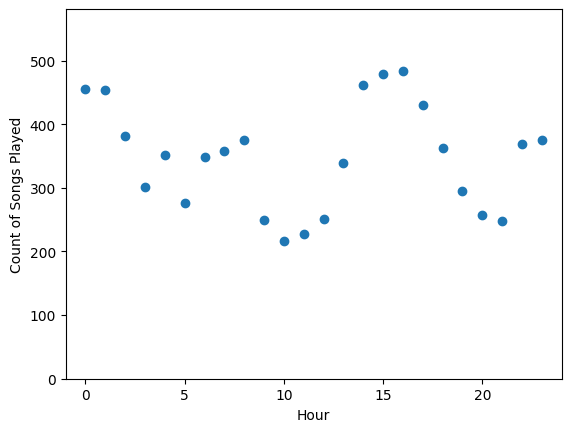

In [11]:
# Scatterplot
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Count of Songs Played")

### Data Operations

In [12]:
# Buscar y eliminar valores omitidos: sólo NA en userId y/o sessionId
valid_users = user_data.dropna(how = "any", subset = ["userId", "sessionId"])
valid_users.count()

10000

In [13]:
# Eliminar duplicados: eliminar Dup, ordenar por ID de usuario
(valid_users
 .select("userId")
 .dropDuplicates()
 .sort("userId")
 .show())

+------+
|userId|
+------+
|      |
|    10|
|   100|
|  1000|
|  1003|
|  1005|
|  1006|
|  1017|
|  1019|
|  1020|
|  1022|
|  1025|
|  1030|
|  1035|
|  1037|
|   104|
|  1040|
|  1042|
|  1043|
|  1046|
+------+
only showing top 20 rows



In [14]:
# Eliminar cadenas vacías
valid_users = valid_users.filter(valid_users["userId"] != "")
valid_users.count()

9664

In [15]:
# ¿Hay usuarios que bajan de categoría?
valid_users.filter(valid_users["page"] == "Submit Downgrade").show()

# Dar a los que bajan de categoría una bandera; primero crear la función; segundo dar la bandera a todos los usuarios.
flag_downgrade_event = fct.udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
# withColumn = crea una nueva columna, o toma la actual y pega los valores en ella
valid_users = valid_users.withColumn("downgraded", flag_downgrade_event("page"))

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|  NULL|Logged In|    Kelly|     F|           24|  Newton|  NULL| paid|Houston-The Woodl...|   PUT|Submit Downgrade|1513283366284|     5931|NULL|   307|1513768454284|Mozilla/5.0 (Wind...|  1138|  11|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+


In [17]:
# Trabajar con ventanas
windowval = Window.partitionBy("userId").orderBy(fct.desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
valid_users = valid_users.withColumn("phase", fct.sum("downgraded").over(windowval))
(valid_users
 .select(["userId", "firstname", "ts", "page", "level", "phase"])
 .where(user_data.userId == "1138")
 .sort("ts")
 .collect())

[Row(userId='1138', firstname='Kelly', ts=1513729066284, page='Home', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729066284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729313284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729552284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729783284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730001284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730263284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730518284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730768284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513731182284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firs

## Using Spark SQL

In [18]:
# Crear una vista temporal para ejecutar consultas SQL
user_data.createOrReplaceTempView("user_data_table")

### Create queries

In [19]:
ss.sql('''
       SELECT *
       FROM user_data_table
       LIMIT 2
       ''').show()  # .show es necesario para superar el lazyevaluation de chispa

+-------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----+
|       artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|hour|
+-------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----+
|Showaddywaddy|Logged In|  Kenneth|     M|          112|Matthews|232.93342| paid|Charlotte-Concord...|   PUT|NextSong|1509380319284|     5132|Christmas Tears W...|   200|1513720872284|"Mozilla/5.0 (Win...|  1046|  22|
|   Lily Allen|Logged In|Elizabeth|     F|            7|   Chase|195.23873| free|Shreveport-Bossie...|   PUT|NextSong|1512718541

In [20]:

ss.sql('''
       SELECT userId, count(page)
       FROM user_data_table
       GROUP BY userId
       ''').show()

+------+-----------+
|userId|count(page)|
+------+-----------+
|  2904|          1|
|   691|          4|
|  2294|         62|
|  2162|         39|
|  1436|          2|
|  2088|         14|
|  2275|          5|
|  2756|          8|
|   800|          3|
|  1394|         28|
|   926|          7|
|  1746|          2|
|  2696|          2|
|  1280|          2|
|   870|          2|
|     7|          2|
|  1903|          7|
|   591|          1|
|   613|          4|
|   574|          7|
+------+-----------+
only showing top 20 rows



In [22]:
ss.sql('''
       SELECT userId, firstname, page, song
       FROM user_data_table
       WHERE userId = '1046'
       ''').collect()  # Atención - diferencia entre mostrar y recoger

[Row(userId='1046', firstname='Kenneth', page='NextSong', song='Christmas Tears Will Fall'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Be Wary Of A Woman'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Public Enemy No.1'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Reign Of The Tyrants'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Father And Son'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='No. 5'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Seventeen'),
 Row(userId='1046', firstname='Kenneth', page='Home', song=None),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='War on war'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Killermont Street'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Black & Blue'),
 Row(userId='1046', firstname='Kenneth', page='Logout', song=None),
 Row(userId='1046', firstname='Kenneth'

### Using user defined functions

In [23]:
# Must be registered first
ss.udf.register("get_hour", lambda x: int(dt.datetime.fromtimestamp(x / 1000).hour))

<function __main__.<lambda>(x)>

In [24]:
ss.sql('''
       SELECT userId, AVG(get_hour(ts)) as avg_hour
       FROM user_data_table
       GROUP BY userId
       ''').show()

+------+------------------+
|userId|          avg_hour|
+------+------------------+
|  2904|              22.0|
|   691|               4.0|
|  2294|13.919354838709678|
|  2162|13.128205128205128|
|  1436|              15.0|
|  2088|20.714285714285715|
|  2275|              10.0|
|  2756|             12.75|
|   800|              15.0|
|  1394|11.607142857142858|
|   926|               9.0|
|  1746|              12.0|
|  2696|              13.0|
|  1280|              15.0|
|   870|              15.0|
|     7|              23.0|
|  1903|11.285714285714286|
|   591|              19.0|
|   613|              15.0|
|   574|              16.0|
+------+------------------+
only showing top 20 rows

